# 01 - Data Exploration

This notebook demonstrates how to load and explore the Kaggle Facial Keypoints Detection dataset.

## Overview

- Load training data from CSV files
- Explore data statistics and distributions
- Visualize sample images with keypoints
- Understand the data format and preprocessing

## Dataset Info

- **Source**: [Kaggle Facial Keypoints Detection](https://www.kaggle.com/c/facial-keypoints-detection)
- **Images**: 96x96 grayscale
- **Keypoints**: 15 facial landmarks (30 values: x,y pairs)
- **Training samples**: ~7000 (but only ~2140 have all 15 keypoints)

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Package imports
from facial_keypoints.data.loader import load_data, get_data_statistics
from facial_keypoints.data.download import get_data_info, verify_data
from facial_keypoints.visualization.plotting import plot_keypoints, plot_training_samples

# Display settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)

## 1. Verify Data Availability

First, let's check if the data files are present and get basic info about them.

In [2]:
# Check data status
status = verify_data()
print("Data file status:")
for filename, valid in status.items():
    symbol = "OK" if valid else "MISSING"
    print(f"  {filename}: {symbol}")

if not all(status.values()):
    print("\nData files missing! Run: python scripts/download_data.py --kaggle")

Data file status:
  training.csv: MISSING
  test.csv: MISSING

Data files missing! Run: python scripts/download_data.py --kaggle


In [3]:
# Get detailed data info
info = get_data_info()
print("Dataset Information")
print("=" * 40)
for key, value in info.items():
    print(f"  {key}: {value}")

Dataset Information
  data_dir: data


## 2. Explore Raw CSV Data

Let's look at the raw CSV structure before loading through our preprocessing pipeline.

In [4]:
# Load raw CSV to explore structure
df_raw = pd.read_csv("../data/training.csv")

print(f"Raw dataframe shape: {df_raw.shape}")
print(f"\nColumns ({len(df_raw.columns)}):")
for i, col in enumerate(df_raw.columns):
    print(f"  {i:2d}. {col}")

Raw dataframe shape: (7049, 31)

Columns (31):
   0. left_eye_center_x
   1. left_eye_center_y
   2. right_eye_center_x
   3. right_eye_center_y
   4. left_eye_inner_corner_x
   5. left_eye_inner_corner_y
   6. left_eye_outer_corner_x
   7. left_eye_outer_corner_y
   8. right_eye_inner_corner_x
   9. right_eye_inner_corner_y
  10. right_eye_outer_corner_x
  11. right_eye_outer_corner_y
  12. left_eyebrow_inner_end_x
  13. left_eyebrow_inner_end_y
  14. left_eyebrow_outer_end_x
  15. left_eyebrow_outer_end_y
  16. right_eyebrow_inner_end_x
  17. right_eyebrow_inner_end_y
  18. right_eyebrow_outer_end_x
  19. right_eyebrow_outer_end_y
  20. nose_tip_x
  21. nose_tip_y
  22. mouth_left_corner_x
  23. mouth_left_corner_y
  24. mouth_right_corner_x
  25. mouth_right_corner_y
  26. mouth_center_top_lip_x
  27. mouth_center_top_lip_y
  28. mouth_center_bottom_lip_x
  29. mouth_center_bottom_lip_y
  30. Image


In [5]:
# Check for missing values in each keypoint column
keypoint_cols = [c for c in df_raw.columns if c != 'Image']
missing_counts = df_raw[keypoint_cols].isnull().sum()

print("Missing values per keypoint:")
print("=" * 50)
for col, count in missing_counts.items():
    pct = count / len(df_raw) * 100
    bar = "#" * int(pct / 2)
    print(f"{col:30s}: {count:4d} ({pct:5.1f}%) {bar}")

Missing values per keypoint:
left_eye_center_x             :   10 (  0.1%) 
left_eye_center_y             :   10 (  0.1%) 
right_eye_center_x            :   13 (  0.2%) 
right_eye_center_y            :   13 (  0.2%) 
left_eye_inner_corner_x       : 4778 ( 67.8%) #################################
left_eye_inner_corner_y       : 4778 ( 67.8%) #################################
left_eye_outer_corner_x       : 4782 ( 67.8%) #################################
left_eye_outer_corner_y       : 4782 ( 67.8%) #################################
right_eye_inner_corner_x      : 4781 ( 67.8%) #################################
right_eye_inner_corner_y      : 4781 ( 67.8%) #################################
right_eye_outer_corner_x      : 4781 ( 67.8%) #################################
right_eye_outer_corner_y      : 4781 ( 67.8%) #################################
left_eyebrow_inner_end_x      : 4779 ( 67.8%) #################################
left_eyebrow_inner_end_y      : 4779 ( 67.8%) #################

Samples with ALL 15 keypoints: 2140 (30.4%)
Samples with partial keypoints: 4909 (69.6%)


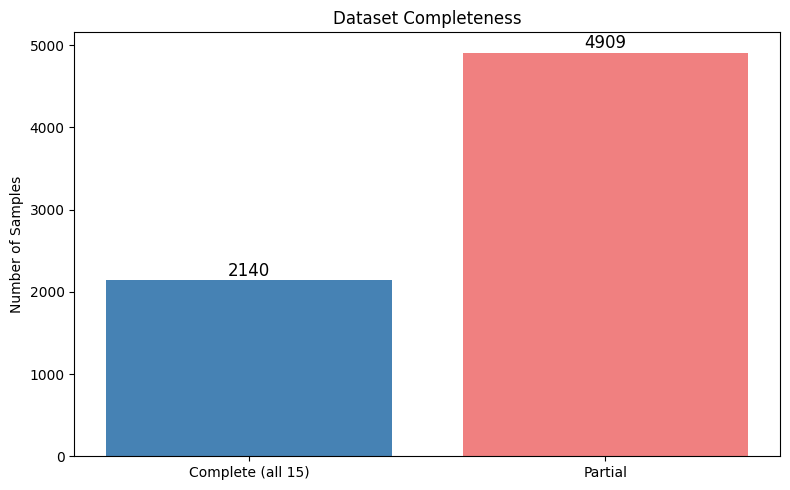

In [6]:
# Samples with ALL keypoints vs partial
complete_mask = df_raw[keypoint_cols].notnull().all(axis=1)
n_complete = complete_mask.sum()
n_partial = len(df_raw) - n_complete

print(f"Samples with ALL 15 keypoints: {n_complete} ({n_complete/len(df_raw)*100:.1f}%)")
print(f"Samples with partial keypoints: {n_partial} ({n_partial/len(df_raw)*100:.1f}%)")

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(['Complete (all 15)', 'Partial'], [n_complete, n_partial], color=['steelblue', 'lightcoral'])
ax.set_ylabel('Number of Samples')
ax.set_title('Dataset Completeness')
for i, v in enumerate([n_complete, n_partial]):
    ax.text(i, v + 50, str(v), ha='center', fontsize=12)
plt.tight_layout()
plt.show()

## 3. Load Preprocessed Training Data

The `load_data()` function:
- Drops rows with missing keypoints (only keeps complete samples)
- Normalizes images to [0, 1]
- Normalizes keypoints to [-1, 1]
- Reshapes images to (N, 96, 96, 1)

In [7]:
# Load preprocessed training data
X_train, y_train = load_data(test=False)

print(f"Training images shape: {X_train.shape}")
print(f"Training keypoints shape: {y_train.shape}")
print(f"\nImage dtype: {X_train.dtype}")
print(f"Keypoints dtype: {y_train.dtype}")
print(f"\nImage value range: [{X_train.min():.4f}, {X_train.max():.4f}]")
print(f"Keypoint value range: [{y_train.min():.4f}, {y_train.max():.4f}]")

DataLoadError: Data file not found: data/training.csv

## 4. Data Statistics

Use `get_data_statistics()` to compute summary statistics for validation and exploration.

In [ ]:
# Compute statistics
stats = get_data_statistics(X_train, y_train)

print("Dataset Statistics")
print("=" * 40)
print(f"Number of samples: {stats['n_samples']}")
print(f"Image dimensions: {stats['image_height']}x{stats['image_width']}")
print(f"Number of keypoints: {stats['n_keypoints']}")
print()
print("Image Value Statistics (normalized [0, 1])")
print(f"  Min: {stats['x_min']:.4f}")
print(f"  Max: {stats['x_max']:.4f}")
print(f"  Mean: {stats['x_mean']:.4f}")
print(f"  Std: {stats['x_std']:.4f}")
print()
print("Keypoint Statistics (normalized [-1, 1])")
print(f"  Min: {stats['y_min']:.4f}")
print(f"  Max: {stats['y_max']:.4f}")
print(f"  Mean: {stats['y_mean']:.4f}")
print(f"  Std: {stats['y_std']:.4f}")

## 5. Visualize Training Samples

The `plot_training_samples()` function displays a grid of images with their keypoints overlaid.

In [ ]:
# Plot a grid of training samples
fig = plot_training_samples(X_train, y_train, n_samples=16, figsize=(14, 14))
plt.suptitle("Training Samples with 15 Facial Keypoints", fontsize=14, y=1.02)
plt.show()

## 6. Individual Sample Visualization

Use `plot_keypoints()` for detailed visualization of a single sample.

In [ ]:
# Visualize a single sample with different marker styles
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Sample index to visualize
idx = 42

# Original image without keypoints
axes[0].imshow(X_train[idx].squeeze(), cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# With cyan keypoints (default)
plot_keypoints(X_train[idx], y_train[idx], ax=axes[1], 
               denormalize=True, marker_color='cyan', marker_size=40)
axes[1].set_title('Cyan Keypoints')

# With red keypoints
plot_keypoints(X_train[idx], y_train[idx], ax=axes[2],
               denormalize=True, marker_color='red', marker_size=60)
axes[2].set_title('Red Keypoints (larger)')

plt.tight_layout()
plt.show()

## 7. Keypoint Distribution Analysis

Analyze the distribution of keypoint positions across the dataset.

In [ ]:
# Keypoint names for reference
KEYPOINT_NAMES = [
    'left_eye_center',
    'right_eye_center', 
    'left_eye_inner_corner',
    'left_eye_outer_corner',
    'right_eye_inner_corner',
    'right_eye_outer_corner',
    'left_eyebrow_inner',
    'left_eyebrow_outer',
    'right_eyebrow_inner',
    'right_eyebrow_outer',
    'nose_tip',
    'mouth_left_corner',
    'mouth_right_corner',
    'mouth_center_top',
    'mouth_center_bottom'
]

print("Keypoint Index Legend:")
for i, name in enumerate(KEYPOINT_NAMES):
    print(f"  {i:2d}: {name}")

In [ ]:
# Denormalize keypoints to pixel coordinates for analysis
y_pixels = y_train * 48 + 48

# Reshape to (n_samples, n_keypoints, 2)
y_reshaped = y_pixels.reshape(-1, 15, 2)

# Compute mean and std position for each keypoint
mean_positions = y_reshaped.mean(axis=0)
std_positions = y_reshaped.std(axis=0)

print("Mean keypoint positions (pixel coords):")
for i, (name, pos, std) in enumerate(zip(KEYPOINT_NAMES, mean_positions, std_positions)):
    print(f"  {i:2d}. {name:25s}: ({pos[0]:5.1f}, {pos[1]:5.1f}) +/- ({std[0]:4.1f}, {std[1]:4.1f})")

In [ ]:
# Plot mean keypoint positions on a reference grid
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(0, 96)
ax.set_ylim(96, 0)  # Invert y-axis (image coordinates)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# Plot mean positions with error ellipses
colors = plt.cm.tab20(np.linspace(0, 1, 15))
for i, (pos, std, color) in enumerate(zip(mean_positions, std_positions, colors)):
    ax.scatter(pos[0], pos[1], s=150, c=[color], marker='o', edgecolors='black', zorder=10)
    ax.annotate(str(i), (pos[0], pos[1]), xytext=(5, 5), textcoords='offset points', 
                fontsize=10, fontweight='bold')

ax.set_title('Mean Keypoint Positions (96x96 image space)', fontsize=14)
ax.set_xlabel('X coordinate (pixels)')
ax.set_ylabel('Y coordinate (pixels)')

plt.tight_layout()
plt.show()

## 8. Pixel Intensity Distribution

In [ ]:
# Plot pixel intensity histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall pixel distribution
axes[0].hist(X_train.flatten(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Pixel Value (normalized 0-1)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Pixel Intensity Distribution')
axes[0].axvline(X_train.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {X_train.mean():.3f}')
axes[0].legend()

# Keypoint coordinate distribution
axes[1].hist(y_train.flatten(), bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Keypoint Coordinate (normalized -1 to 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Keypoint Coordinate Distribution')
axes[1].axvline(y_train.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {y_train.mean():.3f}')
axes[1].legend()

plt.tight_layout()
plt.show()

## 9. Per-Keypoint Distributions

In [ ]:
# Box plot for each keypoint's X and Y coordinates
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# X coordinates (even indices)
x_coords = y_pixels[:, 0::2]  # Shape: (n_samples, 15)
y_coords = y_pixels[:, 1::2]  # Shape: (n_samples, 15)

# X coordinate boxplot
bp1 = axes[0].boxplot(x_coords, labels=range(15), patch_artist=True)
for patch in bp1['boxes']:
    patch.set_facecolor('lightblue')
axes[0].set_ylabel('X coordinate (pixels)')
axes[0].set_xlabel('Keypoint Index')
axes[0].set_title('X Coordinate Distribution per Keypoint')
axes[0].axhline(48, color='red', linestyle='--', alpha=0.5, label='Image center')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Y coordinate boxplot
bp2 = axes[1].boxplot(y_coords, labels=range(15), patch_artist=True)
for patch in bp2['boxes']:
    patch.set_facecolor('lightcoral')
axes[1].set_ylabel('Y coordinate (pixels)')
axes[1].set_xlabel('Keypoint Index')
axes[1].set_title('Y Coordinate Distribution per Keypoint')
axes[1].axhline(48, color='red', linestyle='--', alpha=0.5, label='Image center')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated:

1. **Data Verification**: Using `verify_data()` and `get_data_info()` to check data availability
2. **Raw Data Exploration**: Understanding the CSV structure and missing value patterns
3. **Preprocessed Loading**: Using `load_data()` to get normalized images and keypoints
4. **Statistics**: Using `get_data_statistics()` for dataset validation
5. **Visualization**: Using `plot_keypoints()` and `plot_training_samples()` for visual inspection
6. **Distribution Analysis**: Understanding keypoint distributions and image properties

### Key Findings

- The dataset has ~7000 total samples, but only ~2140 have all 15 keypoints
- Many samples have partial annotations (eyes only, or missing some features)
- The current loader drops partial samples for training consistency
- Keypoints are roughly centered in the images with moderate variance

### Next Steps

- Proceed to `02_model_training.ipynb` to train a CNN model
- Or jump to `03_inference_pipeline.ipynb` to use a pre-trained model